In [1]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import os
import time
import tensorflow as tf
from data_utils.split_data import WordSeqCorpus
from data_utils.data_feed import WordSeqDataFeed
from models.word_seq2seq import Word2SeqAutoEncoder
from config_utils import Word2SeqAutoConfig as Config

# constants
tf.app.flags.DEFINE_string("data_dir", "Data/", "the dir that has the raw corpus file")
tf.app.flags.DEFINE_string("data_file", "open_subtitle.txt", "the file that contains the raw data")
tf.app.flags.DEFINE_string("work_dir", "seq_working/", "Experiment results directory.")
tf.app.flags.DEFINE_string("equal_batch", True, "Make each batch has similar length.")
tf.app.flags.DEFINE_string("max_vocab_size", 20000, "The top N vocabulary we use.")
tf.app.flags.DEFINE_bool("save_model", True, "Create checkpoints")
tf.app.flags.DEFINE_bool("resume", True, "Resume training from the ckp at test_path")
tf.app.flags.DEFINE_bool("forward", True, "Do decoding only")
tf.app.flags.DEFINE_string("test_path", "run1480404404", "the dir to load checkpoint for forward only")
FLAGS = tf.app.flags.FLAGS

In [3]:
 # Load configuration
config = Config()
# for perplexity evaluation
valid_config = Config()
valid_config.keep_prob = 1.0
valid_config.batch_size = 10

# for forward only decoding
test_config = Config()
test_config.keep_prob = 1.0
test_config.batch_size = 10
test_config.beam_size = 20
print(config)

# load corpus
api = WordSeqCorpus(FLAGS.data_dir, FLAGS.data_file, [98,1,1], FLAGS.max_vocab_size,
                    config.max_enc_len, config.max_dec_len, config.line_thres)
corpus_data = api.get_corpus()

# convert to numeric input outputs that fits into TF models
train_feed = WordSeqDataFeed("Train", config,corpus_data["train"], api.vocab)
valid_feed = WordSeqDataFeed("Valid", config,corpus_data["valid"], api.vocab)
test_feed = WordSeqDataFeed("Test", config,corpus_data["test"], api.vocab)

if not os.path.exists(FLAGS.work_dir):
    os.mkdir(FLAGS.work_dir)

if FLAGS.forward or FLAGS.resume:
    log_dir = os.path.join(FLAGS.work_dir, FLAGS.test_path)
else:
    log_dir = os.path.join(FLAGS.work_dir, "run" + str(int(time.time())))
    os.mkdir(log_dir)

# begin training
sess = tf.InteractiveSession()
initializer = tf.random_uniform_initializer(-1*config.init_w, config.init_w)
with tf.variable_scope("model", reuse=None, initializer=initializer):
    model = Word2SeqAutoEncoder(sess, config, len(train_feed.vocab), train_feed.EOS_ID,
                                log_dir=None if FLAGS.forward else log_dir, forward=False)

with tf.variable_scope("model", reuse=True, initializer=initializer):
    valid_model = Word2SeqAutoEncoder(sess, valid_config, len(train_feed.vocab), train_feed.EOS_ID, None, forward=False)

# get a random batch and do forward decoding. Print the most likely response
with tf.variable_scope("model", reuse=True, initializer=initializer):
    test_model = Word2SeqAutoEncoder(sess, test_config, len(train_feed.vocab), train_feed.EOS_ID, None, forward=True)

ckp_dir = os.path.join(log_dir, "checkpoints")

global_t = 0
patience = 10  # wait for at least 10 epoch before consider early stop
valid_loss_threshold = np.inf
best_valid_loss = np.inf
checkpoint_path = os.path.join(ckp_dir, "word2seq.ckpt")

if not os.path.exists(ckp_dir):
    os.mkdir(ckp_dir)

ckpt = tf.train.get_checkpoint_state(ckp_dir)

if ckpt:
    print("Reading models parameters from %s" % ckpt.model_checkpoint_path)
    model.saver.restore(sess, ckpt.model_checkpoint_path)
else:
    print("Created models with fresh parameters.")
    sess.run(tf.initialize_all_variables())


Loaded from cache
Raw vocab cnt 109848 with valid ratio 0.985635
Before cutting. Raw vocab size is 109848 with valid ratio 0.985635
TRAIN encoder avg len 14.82 max len 25.00 of 2706139 lines
TRAIN decoder avg len 7.21 max len 25.00 of 2706139 lines
VALID encoder avg len 14.99 max len 25.00 of 13667 lines
VALID decoder avg len 7.29 max len 25.00 of 13667 lines
TEST encoder avg len 14.96 max len 25.00 of 6717 lines
TEST decoder avg len 7.34 max len 25.00 of 6717 lines
Train feed loads 2706139 samples
Valid feed loads 13667 samples
Test feed loads 6717 samples
Reading models parameters from seq_working/run1480404404/checkpoints/word2seq.ckpt-3


In [4]:
def softmax(w, t = 1.0):
    num_dim = len(w.shape)
    e = np.exp(np.array(w) / t)
    dist = e / np.expand_dims(np.sum(e, axis=num_dim-1), axis=num_dim-1)
    return dist

In [28]:
test_feed.epoch_init(test_config.batch_size, shuffle=True)
fetch = [test_model.decoder_logits, test_model.beam_symbols, test_model.beam_path, 
         test_model.log_beam_probs, test_model.reconstruct_logits]

Test begins with 671 batches


In [57]:
batch = test_feed.next_batch()
encoder_len, decoder_len, encoder_x, decoder_y = batch
feed_dict = {test_model.encoder_batch: encoder_x, test_model.decoder_batch: decoder_y,
             test_model.encoder_lens: encoder_len}
pred, symbol, path, probs, reconstruct = sess.run(fetch, feed_dict)

feed_dict = {valid_model.encoder_batch: encoder_x, valid_model.decoder_batch: decoder_y,
             valid_model.encoder_lens: encoder_len}
valid_logits= sess.run(valid_model.decoder_logits, feed_dict)
valid_logits = softmax(np.swapaxes(np.array(valid_logits), 1,0))

In [58]:
#print probs[0]


In [59]:
beam_symbols_matrix = np.array(symbol)
beam_path_matrix = np.array(path)
beam_log_matrix = np.array(probs)

In [60]:
from models.common_functions import *

In [61]:
b_idx = 1
source = list(encoder_x[b_idx])
ref = list(decoder_y[b_idx, 1:])
ref = [r for r in ref if r not in [test_feed.PAD_ID, test_feed.EOS_ID]]
print " ".join([test_feed.rev_vocab[w] for w in source])
print " ".join([test_feed.rev_vocab[w] for w in ref])

you got two weeks . <t> now , you told me that your wife said that he called it ocean ' s 1 1 .
now , who decided that ?


In [62]:
# remove padding and EOS symbol
b_beam_symbol = beam_symbols_matrix[:, b_idx * test_model.beam_size:(b_idx + 1) * test_model.beam_size]
b_beam_path = beam_path_matrix[:, b_idx * test_model.beam_size:(b_idx + 1) * test_model.beam_size]
b_beam_log = beam_log_matrix[:, b_idx * test_model.beam_size:(b_idx + 1) * test_model.beam_size]
n_best = get_n_best(b_beam_symbol, b_beam_path, b_beam_log, test_model.beam_size, test_feed.EOS_ID)

In [63]:
for score, best in n_best:
    print score
    print " ".join([test_feed.rev_vocab[w] for w in best])

-5.9916305542
yeah .
-6.00712585449
what ?
-6.40257263184
yeah ?
-6.43265533447
okay .
-8.06537628174
all right .
-9.08196258545
well , um
-10.0020599365
all right now
-10.2084884644
that ' s .
-10.4501266479
i ' s .
-10.852355957
well , i said
-11.4989395142
that ' s ...
-11.956741333
yeah , uh ,
-12.7769851685
i ' s the
-14.0683822632
that ' s , i .
-14.6521453857
that ' s , and
-14.9374008179
that ' s UNK_ .
-15.8397979736
well , uh , he
-16.1023712158
that ' s UNK_ ,
-16.5229263306
well , uh , i ' m .
-16.6468048096
well , uh , he said


In [82]:
t_idx = 1
print np.reshape(symbol[t_idx], [test_config.batch_size, test_config.beam_size])[b_idx]
print np.reshape(path[t_idx], [test_config.batch_size, test_config.beam_size])[b_idx]

[ 6  6  6  6  7  6  7  6  7  6  4 53 10  6 10  4  7  7 42  7]
[ 7 10  9 15  5 16  8 11  0 14  9 19  4 18  9 18  2  4  0  1]


In [77]:
top_k_o = np.argsort(valid_logits[b_idx, t_idx])[-20:]
print top_k_o
top_k = np.argsort(valid_logits[b_idx, t_idx] / (1.0 / (np.array(range(1, 20005))*np.log(1.78*20005))))[-20:]
print top_k

[ 44  87  11  88 101  68  56  66  34  65  70  16  84  55  19  22  20  29
   8   9]
[ 7148  2859  9048 14962  9664  3999  4446  2078  3012  1304  1694  4050
  2847  3081  4488  6911 13613 11960  8096  9502]


In [78]:
print [test_feed.rev_vocab[w] for w in top_k_o]
print [test_feed.rev_vocab[w] for w in top_k]

['all', 'okay', 'the', 'yes', 'hey', 'now', 'but', 'she', 'no', 'oh', 'yeah', 'it', 'well', 'so', 'that', 'what', 'and', 'he', 'you', 'i']
['shhh', 'shrek', 'porco', 'hasta', 'eww', 'hyah', 'forrest', 'fifty', 'ouch', 'twenty', 'liar', 'bam', 'fifteen', 'tha', '250', 'ew', 'pepa', 'chuy', 'muriel', 'talon']


In [132]:
np.where(top_k==638)

(array([20000]),)

In [50]:
print " ".join([test_feed.rev_vocab[w] for w in valid_preds[b_idx]])

oh . . EOS_ . EOS_ EOS_ EOS_ EOS_ EOS_ EOS_ EOS_ EOS_ EOS_ EOS_ EOS_ EOS_ EOS_ EOS_ EOS_ EOS_ EOS_ EOS_ EOS_


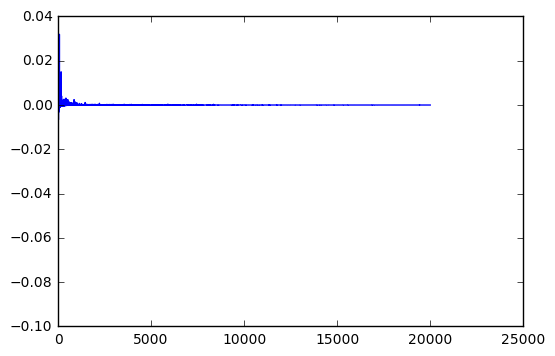

In [151]:
plt.plot(valid_logits[b_idx, 0] - 1.0 / (np.array(range(1, 20005))*np.log(1.78*20005)))

In [131]:
test_feed.vocab['christ']

638

In [133]:
a = [1,2,3,4]

In [175]:
np.log(1.78*20005)

10.48035088559533

In [179]:
np.log(0.1)

-2.3025850929940455

In [4]:
np.log(np.array(range(1,20005))*10.4803)

array([  2.3494973 ,   3.04264448,   3.44810959, ...,  12.25308485,
        12.25313485,  12.25318484])

In [7]:
np.log((np.array(range(1, 20005))*np.log(1.78*20005)))

array([  2.34950216,   3.04264934,   3.44811445, ...,  12.25308971,
        12.2531397 ,  12.25318969])